# RULES


In [15]:
pip install conllu

In [16]:
import pandas as pd
import conllu
from collections import defaultdict
import re
import requests
from conllu import parse

In [17]:
def load_conllu(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()
    return list(conllu.parse(data))

In [4]:
def extract_english_constructions(sentences):
    results = []

    for sentence in sentences:
        if not hasattr(sentence, 'metadata') or not isinstance(sentence.metadata, dict):
            continue

        try:
            tokens = {t['id']: t for t in sentence if isinstance(safe_get(t, 'id'), int)}
            root = [t for t in tokens.values() if t.get('deprel') == 'root']

            if not root:
                continue

            root = root[0]
            text = safe_get(sentence.metadata, 'text', ' '.join([safe_get(t, 'form', '') for t in tokens.values()]))

            # Rule 1: Interrogative-Polar-Direct
            if (root.get('upos') == 'VERB' and
                any(t.get('deprel') in ('aux', 'cop') and t.get('id') < root.get('id') for t in tokens.values()) and
                any(t.get('deprel') == 'nsubj' and t.get('head') == root.get('id') for t in tokens.values()) and
                any(t.get('deprel') == 'punct' and t.get('form') == '?' for t in tokens.values()) and
                not any(t.get('lemma') in ['who', 'what', 'when', 'why', 'whom', 'which', 'whose', 'how', 'where']
                       for t in tokens.values()) and
                not any(t.get('upos') == 'NOUN' and
                       any(d.get('deprel') == 'det' and d.get('lemma') in ['what', 'which', 'whose']
                           for d in tokens.values() if d.get('head') == t.get('id'))
                       for t in tokens.values())):
                results.append((text, 'Interrogative-Polar-Direct', 'english'))

            if (root.get('lemma') == 'be' and
                any(t.get('deprel') == 'expl' and t.get('head') == root.get('id') for t in tokens.values())):
                results.append((text, 'Interrogative-Polar-Direct', 'english'))

            # Rule 2: NPN
            for noun1 in [t for t in tokens.values() if t.get('upos') == 'NOUN']:
                for prep in [t for t in tokens.values() if t.get('upos') == 'ADP' and t.get('head') == noun1.get('id')]:
                    for noun2 in [t for t in tokens.values() if t.get('upos') == 'NOUN' and t.get('head') == prep.get('id')]:
                        if (noun1.get('lemma') == noun2.get('lemma') and
                            not any(t.get('lemma') == 'from' and t.get('deprel') == 'case' and t.get('head') == noun1.get('id')
                                   for t in tokens.values()) and
                            not any(t.get('deprel') == 'fixed' and t.get('head') == noun1.get('id')
                                   for t in tokens.values())):
                            results.append((text, 'NPN', 'english'))

            # Rule 3: Interrogative-WHInfo-Indirect
            for verb in [t for t in tokens.values() if t.get('xpos', '').startswith('V')]:
                for comp in [t for t in tokens.values() if t.get('deprel') in ('ccomp', 'xcomp') and t.get('head') == verb.get('id')]:
                    wh_words = [t for t in tokens.values() if t.get('lemma') in ['who', 'what', 'when', 'how', 'why', 'which', 'whose', 'whom', 'where']]

                    if any(w.get('head') == comp.get('id') for w in wh_words):
                        results.append((text, 'Interrogative-WHInfo-Indirect', 'english'))

                    if (comp.get('lemma') in ['who', 'what', 'when', 'how', 'why', 'which', 'whose', 'whom', 'where'] and
                        not any(t.get('lemma') == 'if' and t.get('head') == comp.get('id') for t in tokens.values())):
                        results.append((text, 'Interrogative-WHInfo-Indirect', 'english'))

            # Rule 4: Existential-CopPred-ThereExpl
            if (root.get('lemma') == 'be' and
                any(t.get('deprel').endswith('subj') and t.get('head') == root.get('id') for t in tokens.values()) and
                any(t.get('xpos') == 'EX' for t in tokens.values())):
                results.append((text, 'Existential-CopPred-ThereExpl', 'english'))

            # Rule 5: Interrogative-WHInfo-Direct
            if any(t.get('deprel') == 'punct' and t.get('form') == '?' for t in tokens.values()):
                wh_words = [t for t in tokens.values() if t.get('lemma') in ['who', 'what', 'when', 'how', 'why', 'which', 'whose', 'whom', 'where']]

                if any(w.get('head') == root.get('id') for w in wh_words):
                    results.append((text, 'Interrogative-WHInfo-Direct', 'english'))

                if (root.get('lemma') in ['who', 'what', 'when', 'how', 'why', 'which', 'whose', 'whom', 'where'] and
                    not any(t.get('lemma') == 'if' and t.get('head') == root.get('id') for t in tokens.values())):
                    results.append((text, 'Interrogative-WHInfo-Direct', 'english'))

            # Rule 6: Interrogative-Polar-Indirect
            for verb in [t for t in tokens.values() if t.get('xpos', '').startswith('V')]:
                for comp in [t for t in tokens.values() if t.get('deprel') in ('ccomp', 'xcomp') and t.get('head') == verb.get('id')]:
                    if any(t.get('lemma') == 'if' and t.get('head') == comp.get('id') for t in tokens.values()):
                        results.append((text, 'Interrogative-Polar-Indirect', 'english'))

        except Exception as e:
            print(f"Error processing sentence: {str(e)}")
            continue

    return results

In [5]:
def extract_french_constructions(sentences):
    results = []

    for sentence in sentences:
        if not hasattr(sentence, 'metadata') or not isinstance(sentence.metadata, dict):
            continue

        try:
            tokens = {}
            for t in sentence:
                token_id = safe_get(t, 'id')
                if isinstance(token_id, int):
                    tokens[token_id] = t

            if not tokens:
                continue

            root = [t for t in tokens.values() if safe_get(t, 'deprel') == 'root']
            if not root:
                continue

            root = root[0]
            text = safe_get(sentence.metadata, 'text', ' '.join([safe_get(t, 'form', '') for t in tokens.values()]))

            # Rule 1: Interrogative-Polar-Direct
            if text and (text.endswith('?') or text.endswith('？')):
                has_interrogative_pronoun = any(safe_get(t, 'PronType') == 'Int' for t in tokens.values())
                has_conj_ou = any(
                    safe_get(t, 'form', '').lower() == 'ou' and
                    any(safe_get(d, 'deprel') == 'cc' for d in tokens.values())
                    for t in tokens.values()
                )
                if not has_interrogative_pronoun and not has_conj_ou:
                    results.append((text, 'Interrogative-Polar-Direct', 'french'))

            # Rule 2: NPN
            if len(tokens) >= 3:
                for i in range(1, len(tokens)-2):
                    t1 = tokens.get(i)
                    t2 = tokens.get(i+1)
                    t3 = tokens.get(i+2)

                    if (t1 and t2 and t3 and
                        safe_get(t1, 'upos') == 'NOUN' and
                        safe_get(t3, 'upos') == 'NOUN' and
                        safe_get(t1, 'form', '').lower() == safe_get(t3, 'form', '').lower() and
                        safe_get(t2, 'form', '').lower() in ['de', 'à', 'par', 'pour', 'en']):

                        has_case = any(
                            safe_get(d, 'deprel') == 'case' and
                            safe_get(d, 'head') == t1['id']
                            for d in tokens.values()
                        )
                        has_fixed = any(
                            safe_get(d, 'deprel') == 'fixed' and
                            safe_get(d, 'head') == t1['id']
                            for d in tokens.values()
                        )
                        if not has_case and not has_fixed:
                            results.append((text, 'NPN', 'french'))
                            break

            # Rule 3: Existential-CopPred-ThereExpl
            for i in range(1, len(tokens)-1):
                t1 = tokens.get(i)
                t2 = tokens.get(i+1)
                t3 = tokens.get(i+2)
                if (t1 and t2 and t3 and
                    safe_get(t1, 'form', '').lower() == 'il' and
                    safe_get(t2, 'form', '').lower() == 'y' and
                    safe_get(t3, 'lemma', '').lower() in ['avoir']):
                    results.append((text, 'Existential-CopPred-ThereExpl', 'french'))
                    break

            # Rule 4: Interrogative-WHInfo-Indirect
            if text and not (text.endswith('?') or text.endswith('？')):
                for token in tokens.values():
                    if safe_get(token, 'PronType') == 'Int':
                        has_conj_or_det = any(
                            safe_get(d, 'deprel') in ('conj', 'det') and
                            safe_get(d, 'head') == token['id']
                            for d in tokens.values()
                        )
                        if not has_conj_or_det:
                            results.append((text, 'Interrogative-WHInfo-Indirect', 'french'))
                            break

            # Rule 5: Interrogative-WHInfo-Direct
            if text and (text.endswith('?') or text.endswith('？')):
                for token in tokens.values():
                    if safe_get(token, 'PronType') == 'Int' and token['id'] == max(tokens.keys()):
                        results.append((text, 'Interrogative-WHInfo-Direct', 'french'))
                        break

            # Rule 6: Interrogative-Polar-Indirect
            if text and not (text.endswith('?') or text.endswith('？')):
                for token in tokens.values():
                    if safe_get(token, 'lemma') == 'si' and safe_get(token, 'upos') == 'SCONJ':
                        for clause in tokens.values():
                            deps = safe_get(clause, 'deps', [])
                            if (safe_get(clause, 'deprel') == 'ccomp' and
                                token['id'] in (deps if deps else [])):
                                results.append((text, 'Interrogative-Polar-Indirect', 'french'))
                                break

            # Rule 7: Conditional-NeutralEpistemic
            for token in tokens.values():
                if safe_get(token, 'lemma') == 'si' and safe_get(token, 'upos') == 'SCONJ':
                    for clause in tokens.values():
                        deps = safe_get(clause, 'deps', [])
                        if (safe_get(clause, 'deprel') == 'advcl' and
                            token['id'] in (deps if deps else [])):
                            has_meme_si = any(
                                safe_get(t, 'lemma') == 'même' and
                                safe_get(t, 'head') == clause['id'] and
                                safe_get(t, 'deprel') == 'advmod'
                                for t in tokens.values()
                            )
                            has_cond_tense = any(
                                safe_get(t, 'Mood') == 'Cnd' or
                                ('Tense' in safe_get(t, 'feats', '') and 'Imp' in safe_get(t, 'feats', ''))
                                for t in tokens.values() if safe_get(t, 'head') == clause['id']
                            )
                            if not has_meme_si and not has_cond_tense:
                                results.append((text, 'Conditional-NeutralEpistemic', 'french'))
                                break

        except Exception as e:
            print(f"Error processing sentence: {str(e)}")
            continue

    return results

In [6]:
def extract_chinese_constructions(sentences):
    results = []

    for sentence in sentences:
        if not hasattr(sentence, 'metadata') or not isinstance(sentence.metadata, dict):
            continue

        try:
            tokens = {}
            for t in sentence:
                token_id = safe_get(t, 'id')
                if isinstance(token_id, int):
                    tokens[token_id] = t

            if not tokens:
                continue

            root = [t for t in tokens.values() if safe_get(t, 'deprel') == 'root']
            if not root:
                continue

            root = root[0]
            text = safe_get(sentence.metadata, 'text', ' '.join([safe_get(t, 'form', '') for t in tokens.values()]))

            # Rule 1: Interrogative-Polar-Direct
            if any(safe_get(t, 'form') == '嗎' for t in tokens.values()):
                results.append((text, 'Interrogative-Polar-Direct', 'chinese'))

            for token in tokens.values():
                if safe_get(token, 'upos') in ('VERB', 'ADJ'):
                    neg_markers = [t for t in tokens.values()
                                 if safe_get(t, 'form') in ['不', '沒'] and
                                 safe_get(t, 'head') == token['id'] and
                                 safe_get(t, 'deprel') == 'advmod']

                    if neg_markers:
                        repetitions = [t for t in tokens.values()
                                     if safe_get(t, 'form') == safe_get(token, 'form') and
                                     t['id'] != token['id'] and
                                     any(safe_get(t_neg, 'head') == t['id'] for t_neg in neg_markers)]

                        if repetitions:
                            has_intervening = any(
                                safe_get(t, 'head') == token['id'] and
                                safe_get(t, 'form') not in ['不', '沒'] and
                                safe_get(t, 'deprel') != 'punct'
                                for t in tokens.values()
                            )

                            if not has_intervening:
                                results.append((text, 'Interrogative-Polar-Direct', 'chinese'))
                                break

            # Rule 2: Interrogative-WHInfo-Direct
            if text and (text.endswith('？') or text.endswith('?')):
                wh_words = ['怎', '怎麼', '什麼', '誰', '為什麼', '哪兒', '哪裡',
                          '哪裏', '幾', '多少', '哪', '幹麼', '怎樣', '甚麼']

                for token in tokens.values():
                    if ((safe_get(token, 'lemma') in wh_words or
                        safe_get(token, 'form') in wh_words) and
                        token['id'] != root['id']):
                        results.append((text, 'Interrogative-WHInfo-Direct', 'chinese'))
                        break

                if ((safe_get(root, 'lemma') in wh_words or
                    safe_get(root, 'form') in wh_words)):
                    results.append((text, 'Interrogative-WHInfo-Direct', 'chinese'))

            # Rule 3: Conditional-NeutralEpistemic
            for token in tokens.values():
                if safe_get(token, 'lemma') == '如果' and safe_get(token, 'upos') == 'SCONJ':
                    protasis = [t for t in tokens.values()
                              if token['id'] in safe_get(t, 'deps', []) and
                              safe_get(t, 'deprel') == 'advcl']

                    if protasis:
                        protasis = protasis[0]
                        apodosis = [t for t in tokens.values()
                                   if safe_get(t, 'id') == safe_get(protasis, 'head')]

                        if apodosis:
                            results.append((text, 'Conditional-NeutralEpistemic', 'chinese'))
                            break

        except Exception as e:
            print(f"Error processing sentence: {str(e)}")
            continue

    return results

In [7]:
def safe_get(d, key, default=None):
    if not isinstance(d, dict):
        return default
    return d.get(key, default)

def extract_constructions(sentences, language):
    if language == 'english':
        return extract_english_constructions(sentences)
    if language == 'french':
        return extract_french_constructions(sentences)
    if language == 'chinese':
        return extract_chinese_constructions(sentences)

In [ ]:
# From URL
def load_ud_treebank(url):
    response = requests.get(url)
    response.raise_for_status()
    return list(conllu.parse(response.text))


def main():
    treebank_urls = {
        'english': 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu',
        'french': 'https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-train.conllu',
        'chinese': 'https://raw.githubusercontent.com/UniversalDependencies/UD_Chinese-HK/master/zh_hk-ud-test.conllu'
    }

    all_results = []

    for lang, url in treebank_urls.items():
        print(f"Processing {lang} treebank...")
        try:
            sentences = load_ud_treebank(url)
            constructions = extract_constructions(sentences, lang)
            all_results.extend(constructions)
            print(f"Found {len(constructions)} constructions in {lang}")
        except Exception as e:
            print(f"Error processing {lang}: {str(e)}")

    df = pd.DataFrame(all_results, columns=['sentence', 'construction_type', 'language'])

    df.to_csv('ud_constructions.csv', index=False, encoding='utf-8')
    print("\nSaved constructions to ud_constructions.csv")

if __name__ == '__main__':
    main()

In [9]:
# Locally
def load_conllu(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()
    return list(conllu.parse(data))


def main():
    treebank_files = {
        'english': 'en_ewt-ud-train.conllu',
        'french': 'fr_gsd-ud-train.conllu',
        'chinese': 'zh_hk-ud-test.conllu'
    }

    all_results = []

    for lang, files in treebank_files.items():
        print(f"Processing {lang} treebank...")
        try:
            sentences = load_conllu(files)
            constructions = extract_constructions(sentences, lang)
            all_results.extend(constructions)
            print(f"Found {len(constructions)} constructions in {lang}")
        except Exception as e:
            print(f"Error processing {lang}: {str(e)}")

    df = pd.DataFrame(all_results, columns=['sentence', 'construction_type', 'language'])

    df.to_csv('ud_constructions.csv', index=False, encoding='utf-8')
    print("\nSaved constructions to ud_constructions.csv")

if __name__ == '__main__':
    main()

Processing english treebank...
Found 1120 constructions in english
Processing french treebank...
Found 341 constructions in french
Processing chinese treebank...
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is not iterable
Error processing sentence: argument of type 'NoneType' is

# METRICS


In [9]:
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
import os
from typing import Tuple

In [10]:
def load_gold_standard(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = f.read()
        sentences = list(conllu.parse(data))

        gold_data = []
        for sentence in sentences:
            if not hasattr(sentence, 'metadata'):
                continue

            text = sentence.metadata.get('text', '')
            if not text:
                continue

            constructions = set()
            for token in sentence:
                if not isinstance(token.get('id'), int):
                    continue
                if 'misc' in token and token['misc']:
                    cxn = token['misc'].get('Cxn')
                    if cxn:
                        constructions.add(cxn)

            for cxn in constructions:
                gold_data.append({
                    'text': text,
                    'construction': cxn,
                    'language': os.path.basename(file_path).split('_')[2].split('-')[0]
                })

        return gold_data
    except Exception as e:
        print(f"Error loading gold standard {file_path}: {str(e)}")
        return []

In [11]:
def evaluate_predictions(pred_file, gold_files):
    try:
        pred_df = pd.read_csv(pred_file)
    except Exception as e:
        print(f"Error loading predictions: {str(e)}")
        return None

    gold_data = []
    for file_path in gold_files:
        gold_data.extend(load_gold_standard(file_path))
    gold_df = pd.DataFrame(gold_data)

    if gold_df.empty:
        print("No gold standard data loaded")
        return None

    metrics = {
        'all': {
            'overall': {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}
        },
        'by_type': defaultdict(lambda: {
            'overall': {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}
        }),
        'by_lang': defaultdict(lambda: {
            'overall': {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.0}
        }),
        'detailed': []
    }

    total_negatives = defaultdict(int)
    for _, gold_row in gold_df.iterrows():
        gold_type = gold_row['construction']
        total_negatives[gold_type] += 1

    for _, pred_row in pred_df.iterrows():
        pred_text = pred_row['sentence']
        pred_type = pred_row['construction_type']
        pred_lang = pred_row['language']

        gold_matches = gold_df[
            (gold_df['text'] == pred_text) &
            (gold_df['language'] == pred_lang)
        ]

        if not gold_matches.empty:
            if pred_type in gold_matches['construction'].values:
                metrics['all']['overall']['tp'] += 1
                metrics['by_type'][pred_type]['overall']['tp'] += 1
                metrics['by_lang'][pred_lang]['overall']['tp'] += 1
                metrics['detailed'].append({
                    'text': pred_text,
                    'predicted': pred_type,
                    'actual': pred_type,
                    'language': pred_lang,
                    'match': 'TP'
                })
            else:
                metrics['all']['overall']['fp'] += 1
                metrics['by_type'][pred_type]['overall']['fp'] += 1
                metrics['by_lang'][pred_lang]['overall']['fp'] += 1
                metrics['detailed'].append({
                    'text': pred_text,
                    'predicted': pred_type,
                    'actual': gold_matches['construction'].values[0] if len(gold_matches) > 0 else 'None',
                    'language': pred_lang,
                    'match': 'FP'
                })
        else:
            metrics['all']['overall']['fp'] += 1
            metrics['by_type'][pred_type]['overall']['fp'] += 1
            metrics['by_lang'][pred_lang]['overall']['fp'] += 1
            metrics['detailed'].append({
                'text': pred_text,
                'predicted': pred_type,
                'actual': 'None',
                'language': pred_lang,
                'match': 'FP'
            })

    for _, gold_row in gold_df.iterrows():
        gold_text = gold_row['text']
        gold_type = gold_row['construction']
        gold_lang = gold_row['language']

        pred_matches = pred_df[
            (pred_df['sentence'] == gold_text) &
            (pred_df['language'] == gold_lang)
        ]

        if pred_matches.empty:
            metrics['all']['overall']['fn'] += 1
            metrics['by_type'][gold_type]['overall']['fn'] += 1
            metrics['by_lang'][gold_lang]['overall']['fn'] += 1
            metrics['detailed'].append({
                'text': gold_text,
                'predicted': 'None',
                'actual': gold_type,
                'language': gold_lang,
                'match': 'FN'
            })
        elif gold_type not in pred_matches['construction_type'].values:
            metrics['all']['overall']['fn'] += 1
            metrics['by_type'][gold_type]['overall']['fn'] += 1
            metrics['by_lang'][gold_lang]['overall']['fn'] += 1
            metrics['detailed'].append({
                'text': gold_text,
                'predicted': pred_matches['construction_type'].values[0],
                'actual': gold_type,
                'language': gold_lang,
                'match': 'FN'
            })
        else:
            for cxn_type in total_negatives:
                if cxn_type != gold_type and cxn_type not in pred_matches['construction_type'].values:
                    metrics['by_type'][cxn_type]['overall']['tn'] += 1

    def calculate_metrics(tp: int, fp: int, fn: int, tn: int = 0) -> Tuple[float, float, float, float]:
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        return precision, recall, f1, accuracy

    tp, fp, fn = metrics['all']['overall']['tp'], metrics['all']['overall']['fp'], metrics['all']['overall']['fn']
    tn = sum(metrics['by_type'][cxn_type]['overall']['tn'] for cxn_type in metrics['by_type'])
    metrics['all']['overall']['precision'], metrics['all']['overall']['recall'], metrics['all']['overall']['f1'], metrics['all']['overall']['accuracy'] = calculate_metrics(tp, fp, fn, tn)

    for cxn_type in metrics['by_type']:
        tp = metrics['by_type'][cxn_type]['overall']['tp']
        fp = metrics['by_type'][cxn_type]['overall']['fp']
        fn = metrics['by_type'][cxn_type]['overall']['fn']
        tn = metrics['by_type'][cxn_type]['overall']['tn']
        metrics['by_type'][cxn_type]['overall']['precision'], \
        metrics['by_type'][cxn_type]['overall']['recall'], \
        metrics['by_type'][cxn_type]['overall']['f1'], \
        metrics['by_type'][cxn_type]['overall']['accuracy'] = calculate_metrics(tp, fp, fn, tn)

    for lang in metrics['by_lang']:
        tp = metrics['by_lang'][lang]['overall']['tp']
        fp = metrics['by_lang'][lang]['overall']['fp']
        fn = metrics['by_lang'][lang]['overall']['fn']
        tn = sum(metrics['by_type'][cxn_type]['overall']['tn']
                for cxn_type in metrics['by_type']
                if any(d['language'] == lang and d['actual'] == cxn_type and d['match'] == 'TN'
                      for d in metrics['detailed']))
        metrics['by_lang'][lang]['overall']['precision'], \
        metrics['by_lang'][lang]['overall']['recall'], \
        metrics['by_lang'][lang]['overall']['f1'], \
        metrics['by_lang'][lang]['overall']['accuracy'] = calculate_metrics(tp, fp, fn, tn)

    return metrics

In [12]:
def print_metrics(metrics):
    print("\n=== Overall Metrics ===")
    overall = metrics['all']['overall']
    print(f"Accuracy: {overall['accuracy']:.4f}")
    print(f"Precision: {overall['precision']:.4f}")
    print(f"Recall: {overall['recall']:.4f}")
    print(f"F1 Score: {overall['f1']:.4f}")
    print(f"True Positives: {overall['tp']}")
    print(f"False Positives: {overall['fp']}")
    print(f"False Negatives: {overall['fn']}")

    print("\n=== Metrics by Construction Type ===")
    for cxn_type, cxn_metrics in metrics['by_type'].items():
        print(f"\nConstruction: {cxn_type}")
        print(f"Accuracy: {cxn_metrics['overall']['accuracy']:.4f}")
        print(f"Precision: {cxn_metrics['overall']['precision']:.4f}")
        print(f"Recall: {cxn_metrics['overall']['recall']:.4f}")
        print(f"F1 Score: {cxn_metrics['overall']['f1']:.4f}")
        print(f"True Positives: {cxn_metrics['overall']['tp']}")
        print(f"False Positives: {cxn_metrics['overall']['fp']}")
        print(f"False Negatives: {cxn_metrics['overall']['fn']}")

    print("\n=== Metrics by Language ===")
    for lang, lang_metrics in metrics['by_lang'].items():
        print(f"\nLanguage: {lang}")
        print(f"Accuracy: {lang_metrics['overall']['accuracy']:.4f}")
        print(f"Precision: {lang_metrics['overall']['precision']:.4f}")
        print(f"Recall: {lang_metrics['overall']['recall']:.4f}")
        print(f"F1 Score: {lang_metrics['overall']['f1']:.4f}")
        print(f"True Positives: {lang_metrics['overall']['tp']}")
        print(f"False Positives: {lang_metrics['overall']['fp']}")
        print(f"False Negatives: {lang_metrics['overall']['fn']}")

In [13]:
def save_metrics_to_csv(metrics, output_file):
    data = []

    overall = metrics['all']['overall']
    data.append({
        'type': 'overall',
        'category': 'all',
        'accuracy': overall['accuracy'],
        'precision': overall['precision'],
        'recall': overall['recall'],
        'f1': overall['f1'],
        'true_positives': overall['tp'],
        'false_positives': overall['fp'],
        'false_negatives': overall['fn']
    })

    for cxn_type, cxn_metrics in metrics['by_type'].items():
        data.append({
            'type': 'construction',
            'category': cxn_type,
            'accuracy': cxn_metrics['overall']['accuracy'],
            'precision': cxn_metrics['overall']['precision'],
            'recall': cxn_metrics['overall']['recall'],
            'f1': cxn_metrics['overall']['f1'],
            'true_positives': cxn_metrics['overall']['tp'],
            'false_positives': cxn_metrics['overall']['fp'],
            'false_negatives': cxn_metrics['overall']['fn']
        })

    for lang, lang_metrics in metrics['by_lang'].items():
        data.append({
            'type': 'language',
            'category': lang,
            'accuracy': lang_metrics['overall']['accuracy'],
            'precision': lang_metrics['overall']['precision'],
            'recall': lang_metrics['overall']['recall'],
            'f1': lang_metrics['overall']['f1'],
            'true_positives': lang_metrics['overall']['tp'],
            'false_positives': lang_metrics['overall']['fp'],
            'false_negatives': lang_metrics['overall']['fn']
        })

    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"\nMetrics saved to {output_file}")

In [ ]:
# From URL
def main():
    predictions_file = 'ud_constructions.csv'
    gold_standards = [
        'https://raw.githubusercontent.com/nastyafirs/UDs_data/refs/heads/main/UD%20annotations/ucxn_ud_english-gum.conllu',
        'https://raw.githubusercontent.com/nastyafirs/UDs_data/refs/heads/main/UD%20annotations/ucxn_ud_french-gsd.conllu',
        'https://raw.githubusercontent.com/nastyafirs/UDs_data/refs/heads/main/UD%20annotations/ucxn_ud_chinese-hk.conllu'
    ]
    metrics = evaluate_predictions(predictions_file, gold_standards)
    if metrics:
        print_metrics(metrics)
        save_metrics_to_csv(metrics, 'evaluation_metrics.csv')

if __name__ == '__main__':
    main()

In [18]:
# Locally
def main():
    predictions_file = 'ml_construction_predictions.csv'
    gold_standards = [
        'ucxn_ud_english-ewt.conllu',
        'ucxn_ud_french-gsd.conllu',
        'ucxn_ud_chinese-hk.conllu'
    ]

    missing_files = [f for f in gold_standards if not os.path.exists(f)]
    if missing_files:
        print(f"Error: Missing gold standard files: {', '.join(missing_files)}")
        return

    if not os.path.exists(predictions_file):
        print(f"Error: Prediction file {predictions_file} not found")
        return

    metrics = evaluate_predictions(predictions_file, gold_standards)
    if metrics:
        print_metrics(metrics)
        save_metrics_to_csv(metrics, 'ml_evaluation_metrics.csv')

if __name__ == '__main__':
    main()


=== Overall Metrics ===
Accuracy: 0.1021
Precision: 0.0022
Recall: 0.0193
F1 Score: 0.0040
True Positives: 62
False Positives: 27936
False Negatives: 3151

=== Metrics by Construction Type ===

Construction: NPN
Accuracy: 0.0077
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True Positives: 0
False Positives: 7974
False Negatives: 32

Construction: Interrogative-Polar-Indirect
Accuracy: 0.1462
Precision: 0.0039
Recall: 0.0092
F1 Score: 0.0055
True Positives: 1
False Positives: 254
False Negatives: 108

Construction: Interrogative-WHInfo-Indirect
Accuracy: 0.0177
Precision: 0.0013
Recall: 0.0127
F1 Score: 0.0023
True Positives: 4
False Positives: 3120
False Negatives: 312

Construction: Existential-CopPred-ThereExpl
Accuracy: 0.0443
Precision: 0.0043
Recall: 0.0098
F1 Score: 0.0059
True Positives: 4
False Positives: 933
False Negatives: 404

Construction: Existential-HavePred-ItExpl-ThereExpl
Accuracy: 0.0055
Precision: 0.0001
Recall: 0.0093
F1 Score: 0.0002
True Positives: 1
False 

# Plots

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('ml_evaluation_metrics.csv')

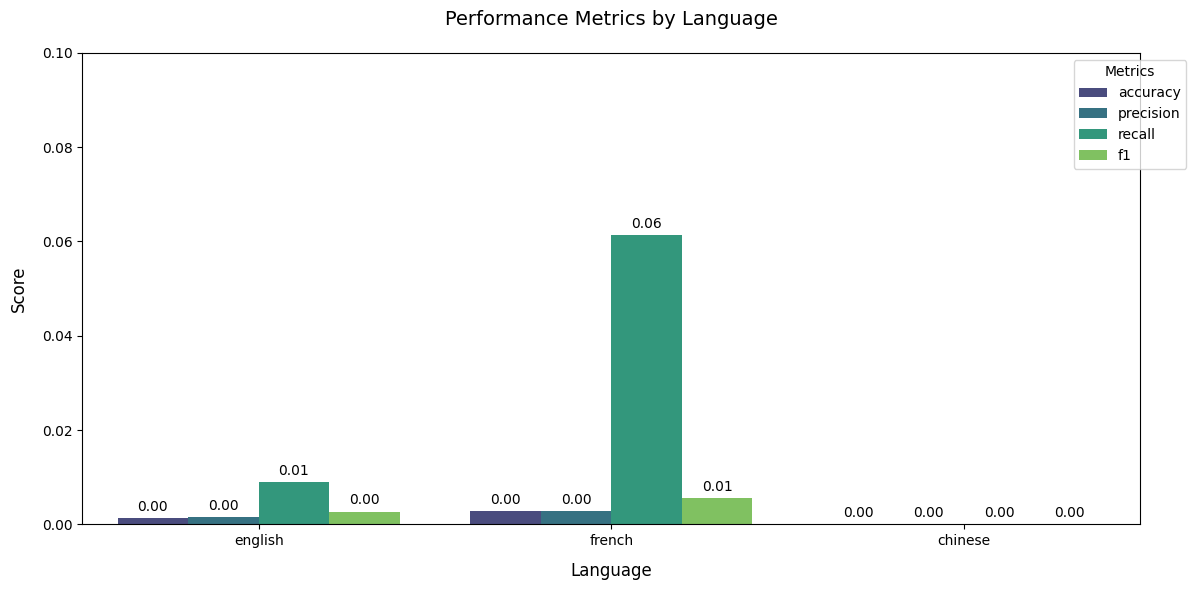

In [24]:
lang_metrics = df[df['type'] == 'language']
lang_melted = lang_metrics.melt(id_vars=['category'],
                              value_vars=['accuracy', 'precision', 'recall', 'f1'],
                              var_name='metric')

plt.figure(figsize=(12, 6))
lang_plot = sns.barplot(x='category', y='value', hue='metric',
                       data=lang_melted, palette='viridis')
plt.title('Performance Metrics by Language', fontsize=14, pad=20)
plt.xlabel('Language', fontsize=12, labelpad=10)
plt.ylabel('Score', fontsize=12, labelpad=10)
plt.ylim(0, 0.1)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1))
for container in lang_plot.containers:
    lang_plot.bar_label(container, fmt='%.2f', padding=3, fontsize=10)
plt.tight_layout()
plt.savefig('language_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

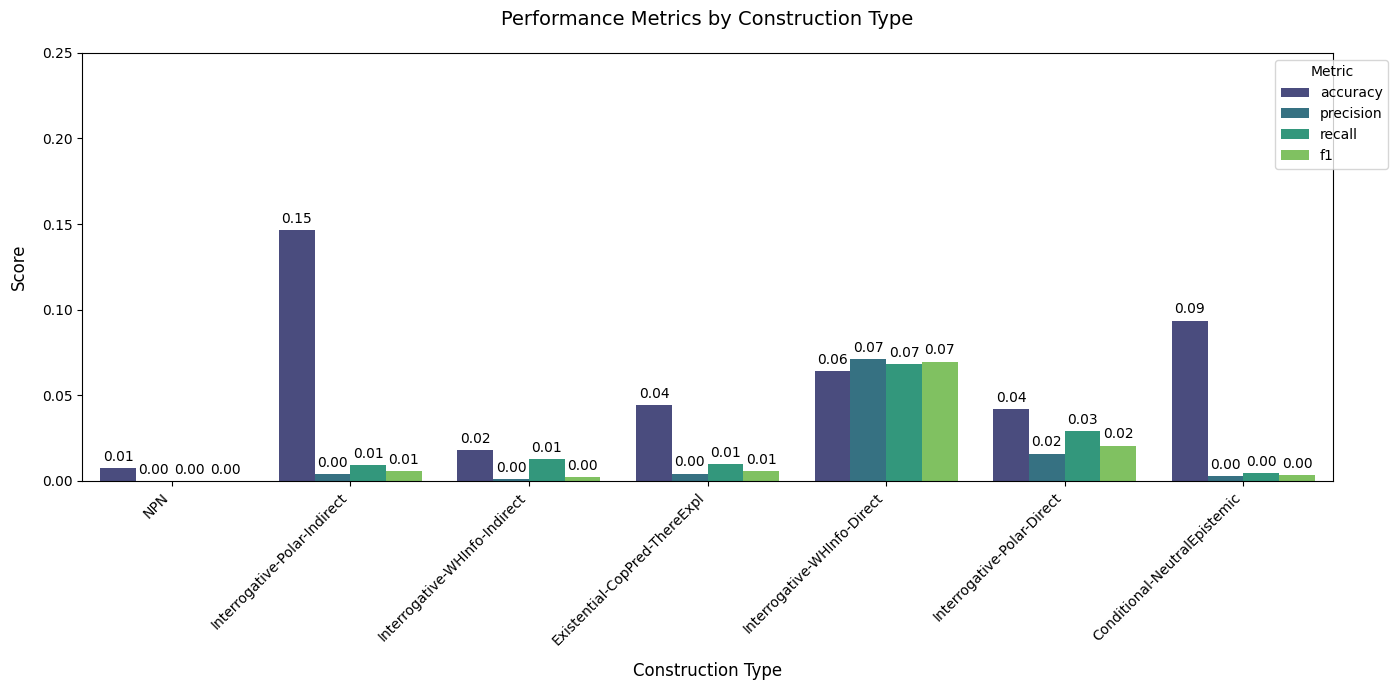

In [27]:
target_constructions = [
    'Interrogative-Polar-Direct',
    'NPN',
    'Existential-CopPred-ThereExpl',
    'Interrogative-WHInfo-Indirect',
    'Interrogative-WHInfo-Direct',
    'Interrogative-Polar-Indirect',
    'Conditional-NeutralEpistemic'
]

constr_metrics = df[(df['type'] == 'construction') &
                   (df['category'].isin(target_constructions))]

plt.figure(figsize=(14, 7))
constr_plot = sns.barplot(x='category', y='value', hue='metric',
                         data=constr_metrics.melt(id_vars=['category'],
                                                 value_vars=['accuracy', 'precision', 'recall', 'f1'],
                                                 var_name='metric'),
                         palette='viridis')
plt.title('Performance Metrics by Construction Type', fontsize=14, pad=20)
plt.xlabel('Construction Type', fontsize=12, labelpad=10)
plt.ylabel('Score', fontsize=12, labelpad=10)
plt.ylim(0, 0.25)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha='right')
for container in constr_plot.containers:
    constr_plot.bar_label(container, fmt='%.2f', padding=3, fontsize=10)
plt.tight_layout()
plt.savefig('construction_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-44-5c2801d421c7>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')
<ipython-input-44-5c2801d421c7>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_error = plt.cm.get_cmap('viridis', len(error_metrics_filtered))


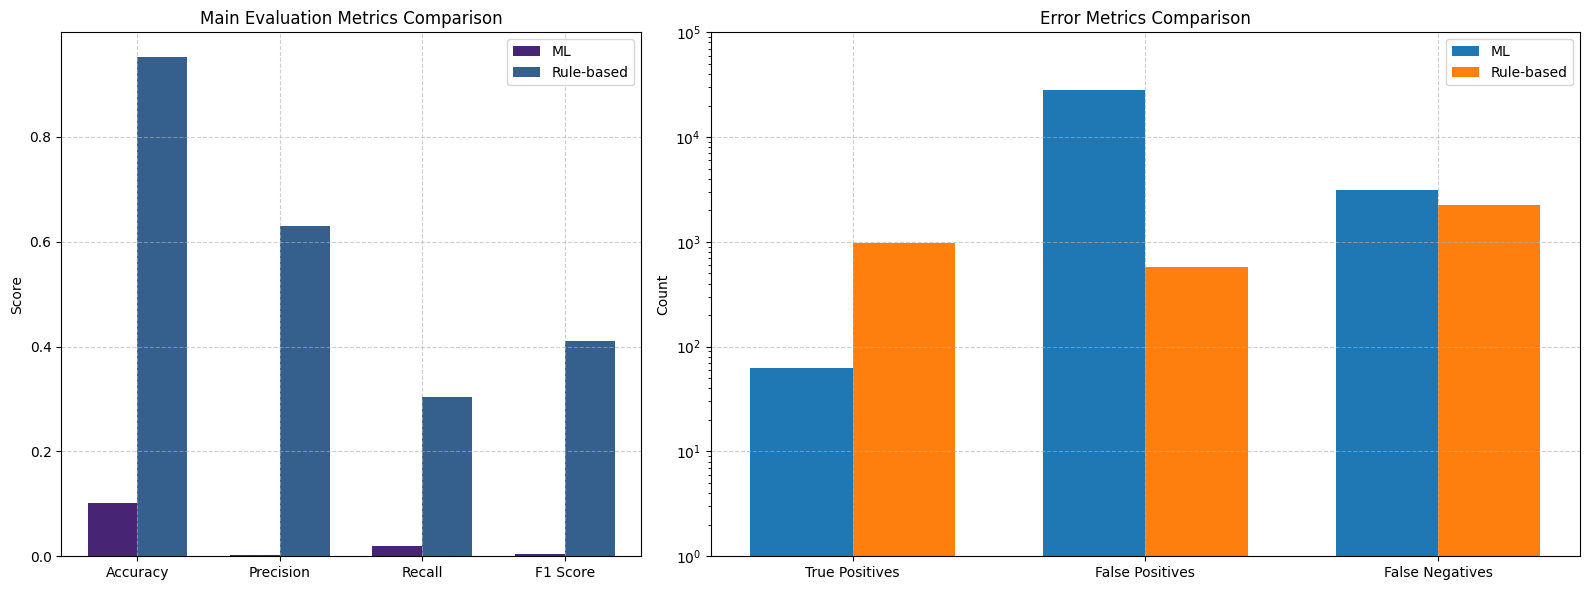

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

df1 = pd.read_csv('ml_evaluation_metrics.csv')
df2 = pd.read_csv('evaluation_metrics (1).csv')

overall1 = df1[df1['type'] == 'overall'].iloc[0]
overall2 = df2[df2['type'] == 'overall'].iloc[0]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values1 = [overall1['accuracy'], overall1['precision'], overall1['recall'], overall1['f1']]
values2 = [overall2['accuracy'], overall2['precision'], overall2['recall'], overall2['f1']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.5]})

x = np.arange(len(metrics))
width = 0.35
viridis = plt.cm.get_cmap('viridis')

ax1.bar(x - width/2, values1, width, label='ML', color=viridis(0.1))
ax1.bar(x + width/2, values2, width, label='Rule-based', color=viridis(0.3))
ax1.set_ylabel('Score')
ax1.set_title('Main Evaluation Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

error_metrics = ['True Positives', 'False Positives', 'False Negatives']
error_values1 = [overall1['true_positives'], overall1['false_positives'], overall1['false_negatives']]
error_values2 = [overall2['true_positives'], overall2['false_positives'], overall2['false_negatives']]

error_metrics_filtered = []
ev1_filtered = []
ev2_filtered = []
for em, ev1, ev2 in zip(error_metrics, error_values1, error_values2):
    if ev1 > 0 or ev2 > 0:
        error_metrics_filtered.append(em)
        ev1_filtered.append(ev1)
        ev2_filtered.append(ev2)

x = np.arange(len(error_metrics_filtered))
viridis_error = plt.cm.get_cmap('viridis', len(error_metrics_filtered))

ax2.bar(x - width/2, ev1_filtered, width, label='ML')
ax2.bar(x + width/2, ev2_filtered, width, label='Rule-based')
ax2.set_ylabel('Count')
ax2.set_title('Error Metrics Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(error_metrics_filtered)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

ax2.set_yscale('log')
ax2.set_ylim(1, 10**5)

plt.tight_layout()
plt.show()

In [38]:
plt.savefig('overall_metrics.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

df1 = pd.read_csv('ml_evaluation_metrics.csv')
df2 = pd.read_csv('evaluation_metrics (1).csv')

overall1 = df1[df1['type'] == 'overall'].iloc[0]
overall2 = df2[df2['type'] == 'overall'].iloc[0]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values1 = [overall1['accuracy'], overall1['precision'], overall1['recall'], overall1['f1']]
values2 = [overall2['accuracy'], overall2['precision'], overall2['recall'], overall2['f1']]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35
viridis = plt.cm.get_cmap('viridis', 4)

plt.bar(x - width/2, values1, width, label='ML', color=viridis(0.1))
plt.bar(x + width/2, values2, width, label='Rule-based', color=viridis(0.3))
plt.ylabel('Score')
plt.title('Main Evaluation Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('main_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

error_metrics = ['True Positives', 'False Positives', 'False Negatives']
error_values1 = [overall1['true_positives'], overall1['false_positives'], overall1['false_negatives']]
error_values2 = [overall2['true_positives'], overall2['false_positives'], overall2['false_negatives']]

error_metrics_filtered = []
ev1_filtered = []
ev2_filtered = []
for em, ev1, ev2 in zip(error_metrics, error_values1, error_values2):
    if ev1 > 0 or ev2 > 0:
        error_metrics_filtered.append(em)
        ev1_filtered.append(ev1)
        ev2_filtered.append(ev2)

plt.figure(figsize=(10, 6))
x = np.arange(len(error_metrics_filtered))
width = 0.35
viridis_error = plt.cm.get_cmap('viridis', len(error_metrics_filtered))

plt.bar(x - width/2, ev1_filtered, width, label='ML', color=viridis_error(0.1))
plt.bar(x + width/2, ev2_filtered, width, label='Rule-based', color=viridis_error(0.3))
plt.ylabel('Count (log scale)')
plt.title('Error Metrics Comparison')
plt.xticks(x, error_metrics_filtered)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.ylim(1, 10**5)
plt.tight_layout()
plt.savefig('error_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

<ipython-input-45-228ce4d40c89>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 4)
<ipython-input-45-228ce4d40c89>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_error = plt.cm.get_cmap('viridis', len(error_metrics_filtered))


Plots saved as:
- main_metrics_comparison.png
- error_metrics_comparison.png
